# <center>**Images**<center>

**Libraries**

In [1]:
import numpy as np
from scipy.signal import correlate

import maskpattern as mp
import plot_module as plot
import balancing as bal
import stats
import iros as sk

np.set_printoptions(precision=2, suppress=False)

**Mask and Decoder**

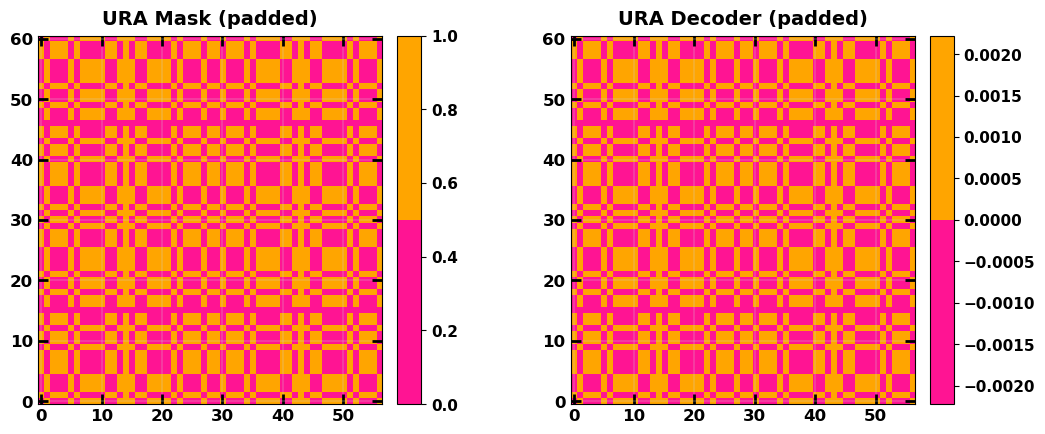

In [2]:
ura = mp.URAMaskPattern(4)
ura_pattern2D, ura_decoder2D = ura.basic_pattern, ura.basic_decoder

n, m = ura_pattern2D.shape
pad_n, pad_m = (n - 1)//2, (m - 1)//2

mask = np.pad(ura_pattern2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')
decoder = np.pad(ura_decoder2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')

plot.image_plot([mask, decoder],
                ["URA Mask (padded)", "URA Decoder (padded)"])

**Images Dimension**

In [3]:
bulk_array_shape = ura_pattern2D.shape    # detector shape == basic pattern
sky_shape = (3*n - 2, 3*m - 2)             # sky shape (FCFOV + PCFOV) == M + D - 1

**Detector**

In [4]:
bulk_array = np.ones(bulk_array_shape)
bulk_array = np.pad(bulk_array, ((n - 1, n - 1), (m - 1, m - 1)))

assert bulk_array.shape == sky_shape

**Sky Image**

In [18]:
import collections.abc as c

def sky_image_simulation(sky_image_shape: tuple[int, int],
                         sources_flux: c.Sequence[int],
                         sources_pos: None | c.Sequence[tuple[int, int]] = None,
                         sky_background_rate: None | int = None,
                         ) -> tuple[c.Sequence, None | c.Sequence]:
    """Simulates the sky image given the sources flux."""

    # generate sky
    if sky_background_rate is None:
        sky_image = np.zeros(sky_image_shape)
    else:
        sky_image = np.random.poisson(sky_background_rate, sky_image_shape)
    
    sky_background = sky_image.copy()

    if sources_pos is None:
        sources_pos = [(np.random.randint(0, sky_image_shape[0]), np.random.randint(0, sky_image_shape[1]))
                       for _ in range(len(sources_flux))]

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]
    
    return sky_image, sky_background, sources_pos

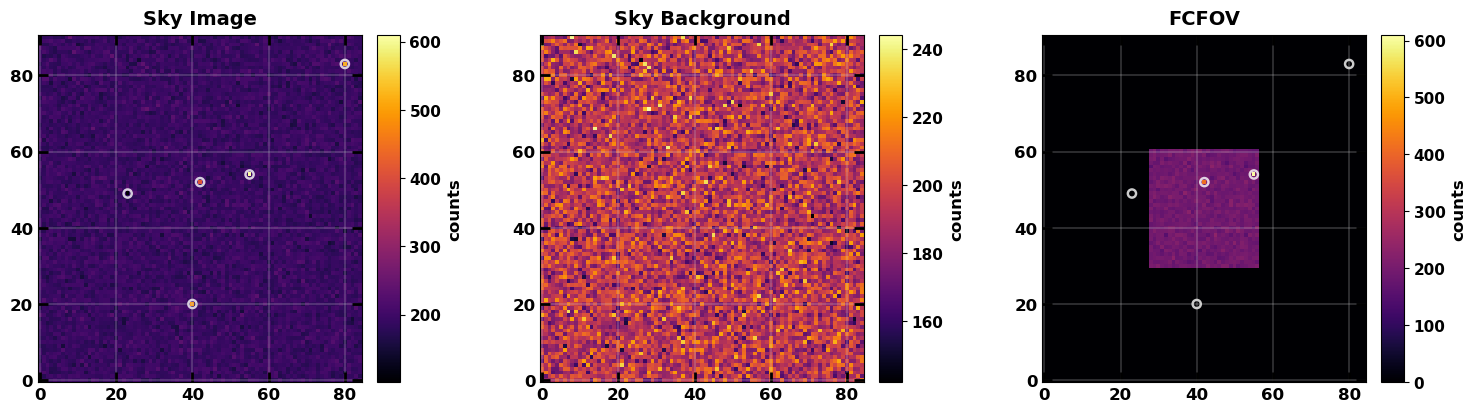

In [19]:
sources_flux = np.random.randint(50, 1000, size=5)
sources_pos = None
sky_background_rate = sources_flux.min() + np.random.randint(0, sources_flux.min())

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)
sky_significance = stats.significance(sky_image, sky_background_rate)

plot.image_plot([sky_image, sky_background, sky_image*bulk_array],
                ["Sky Image", "Sky Background", "FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos, None, sources_pos])

**Test 1**

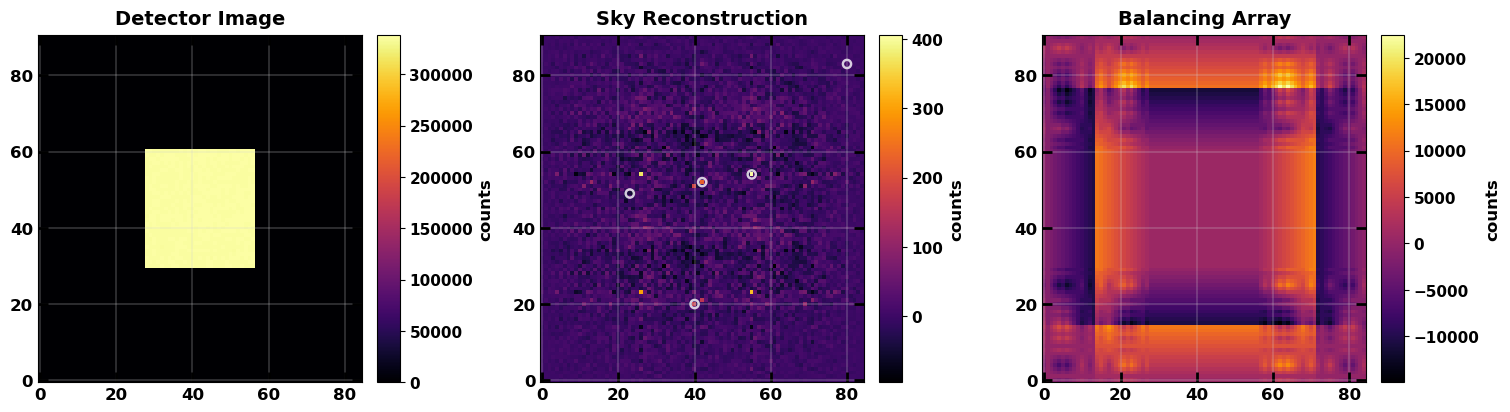

In [22]:
detector_image = correlate(mask, sky_image)[n - 1 : -(n - 1), m - 1 : -(m - 1)]*bulk_array
assert detector_image.shape == sky_shape

bal = correlate(decoder, bulk_array*(detector_image.sum()/bulk_array.sum()))[n - 1 : -(n - 1), m - 1 : -(m - 1)]
sky_reconstruction = correlate(decoder, detector_image)[n - 1 : -(n - 1), m - 1 : -(m - 1)] - bal
assert sky_reconstruction.shape == sky_shape and bal.shape == sky_reconstruction.shape

plot.image_plot([detector_image, sky_reconstruction, bal],
                ["Detector Image", "Sky Reconstruction", "Balancing Array"],
                cbarlabel=["counts"]*3,
                cbarcmap=["inferno"]*3,
                simulated_sources=[None, sources_pos, None])

**Test 2**

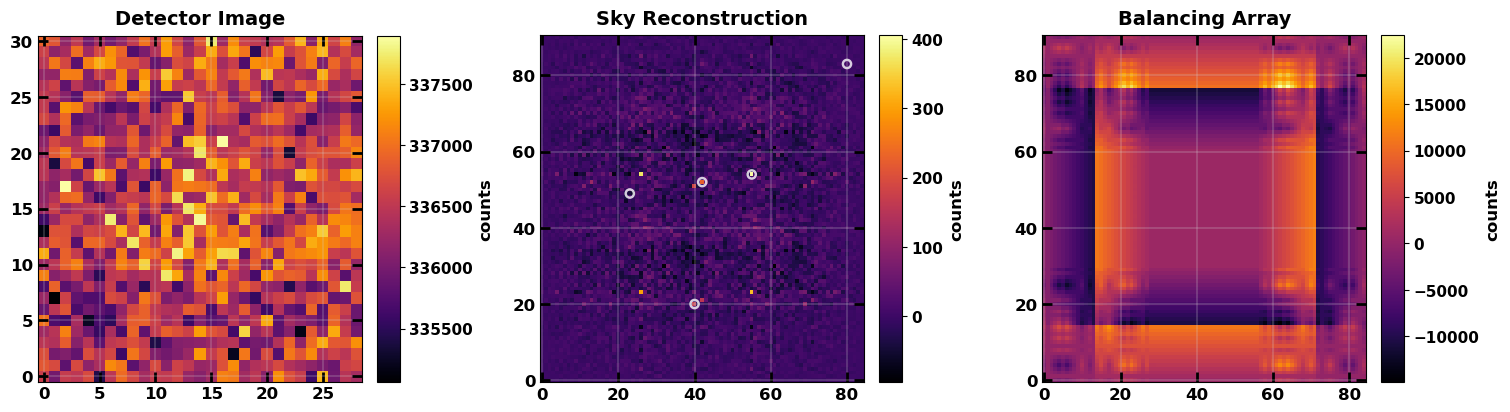

In [23]:
h, v = n - 1, m - 1

cc_detector_image = correlate(mask, sky_image, mode='full')
fcfov_detector_image = cc_detector_image[2*h : -2*h, 2*v : -2*v]
fcfov_bulk_array = np.ones(fcfov_detector_image.shape)

bal = correlate(decoder, fcfov_bulk_array*(fcfov_detector_image.sum()/fcfov_bulk_array.sum()))
sky_reconstruction = correlate(decoder, fcfov_detector_image) - bal
assert sky_reconstruction.shape == sky_shape and bal.shape == sky_reconstruction.shape

plot.image_plot([fcfov_detector_image, sky_reconstruction, bal],
                ["Detector Image", "Sky Reconstruction", "Balancing Array"],
                cbarlabel=["counts"]*3,
                cbarcmap=["inferno"]*3,
                simulated_sources=[None, sources_pos, None])

**Test 3**

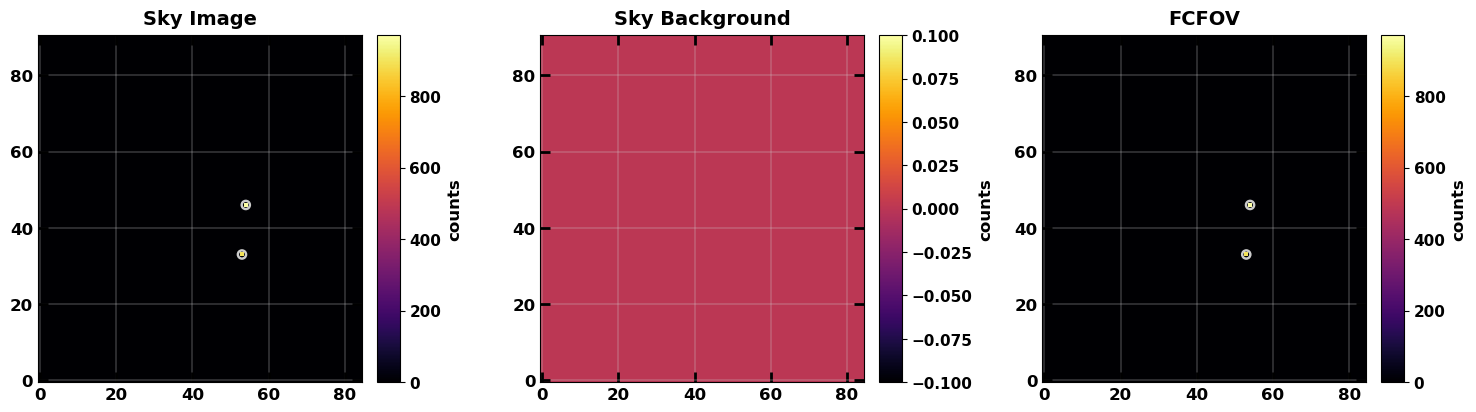

In [26]:
sources_flux = np.random.randint(50, 1000, size=2)
sources_pos = [(np.random.randint(h, h + n), np.random.randint(v, v + m)),
               (np.random.randint(h, h + n), np.random.randint(v, v + m))]
sky_background_rate = 0

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)
sky_significance = stats.significance(sky_image, sky_background_rate)

plot.image_plot([sky_image, sky_background, sky_image*bulk_array],
                ["Sky Image", "Sky Background", "FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos, None, sources_pos])

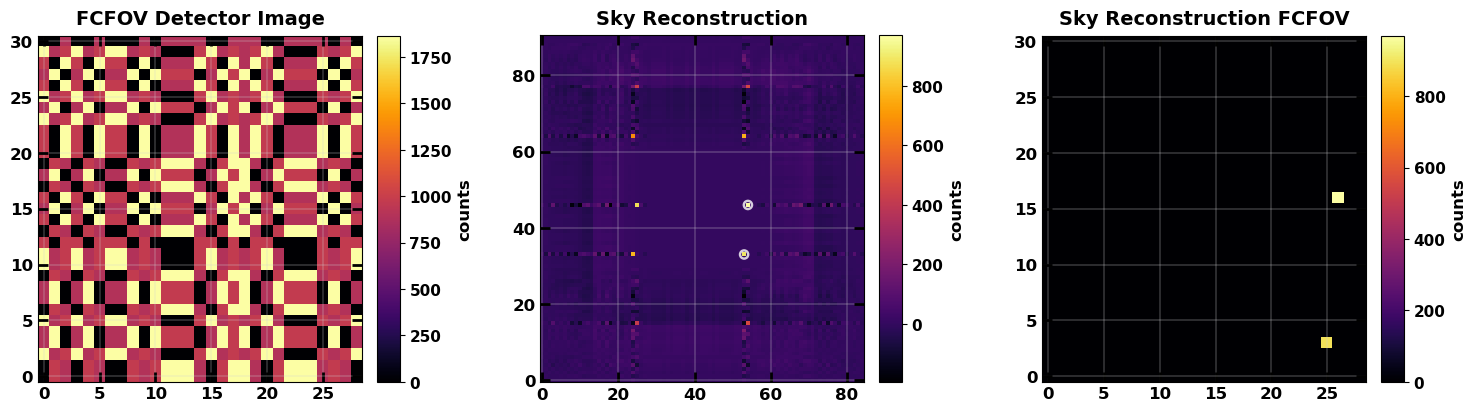

In [33]:
cc_detector_image = correlate(mask, sky_image, mode='full')
fcfov_detector_image = cc_detector_image[2*h : -2*h, 2*v : -2*v]
sky_reconstruction = correlate(decoder, fcfov_detector_image)

plot.image_plot([fcfov_detector_image, sky_reconstruction, sky_reconstruction[h : -h, v : -v]],
                ["FCFOV Detector Image", "Sky Reconstruction", "Sky Reconstruction FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[None, sources_pos, None])

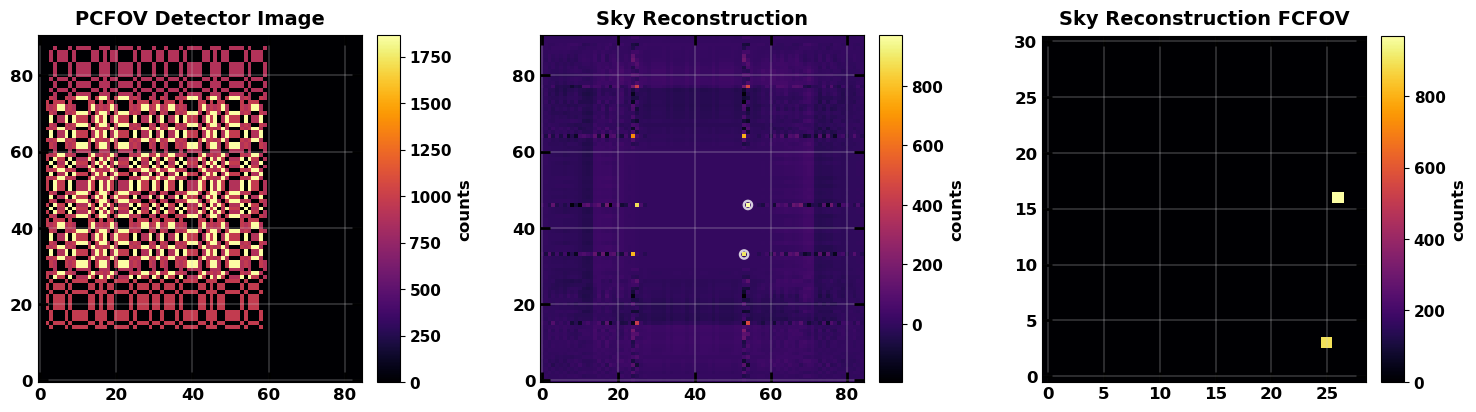

In [36]:
cc_detector_image = correlate(mask, sky_image, mode='full')
pcfov_detector_image = cc_detector_image[h : -h, v : -v]

bulk_array = np.ones(bulk_array_shape)
bulk_array = np.pad(bulk_array, ((n - 1, n - 1), (m - 1, m - 1)))

sky_reconstruction = correlate(decoder, pcfov_detector_image*bulk_array)[h : -h, v : -v]

plot.image_plot([pcfov_detector_image, sky_reconstruction, sky_reconstruction[h : -h, v : -v]],
                ["PCFOV Detector Image", "Sky Reconstruction", "Sky Reconstruction FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[None, sources_pos, None])

**Test 4**

- Let's hand-pad everything

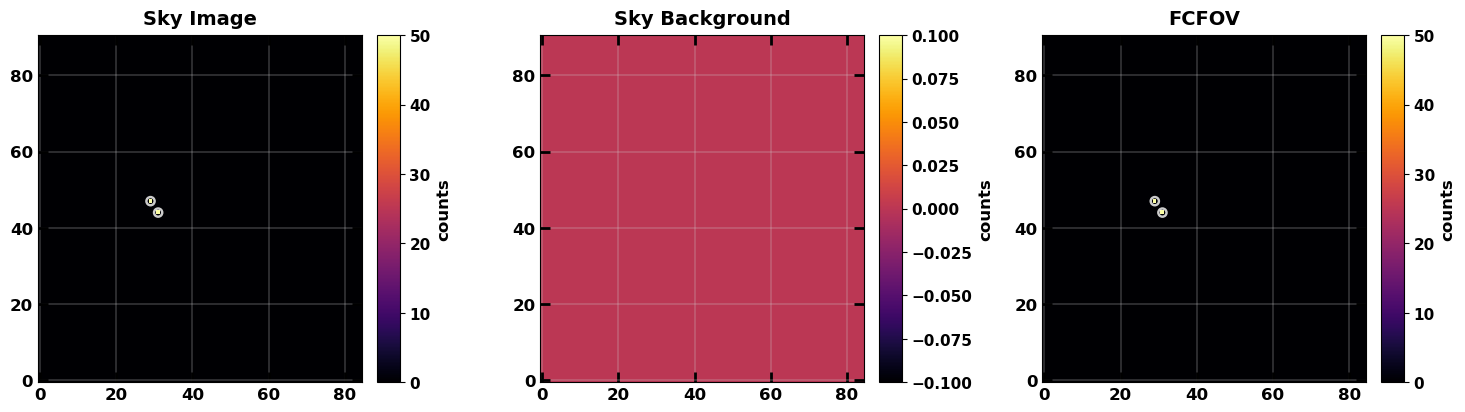

In [38]:
sources_flux = np.array([50]*2)
sources_pos = [(np.random.randint(h, h + n), np.random.randint(v, v + m)),
               (np.random.randint(h, h + n), np.random.randint(v, v + m))]
sky_background_rate = None

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

plot.image_plot([sky_image, sky_background, sky_image*bulk_array],
                ["Sky Image", "Sky Background", "FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos, None, sources_pos])

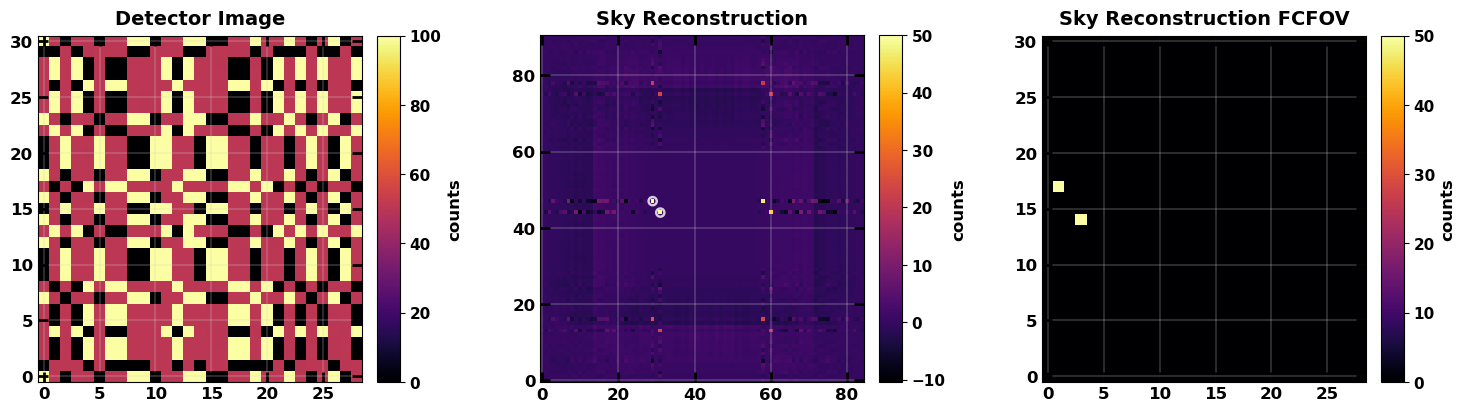

In [44]:
pad_mask = np.pad(mask, ((h, h), (v, v)))
pad_decoder = np.pad(decoder, ((h, h), (v, v)))

detector_image = correlate(pad_mask, sky_image, mode='valid')
assert detector_image.shape == (n, m)

sky_reconstruction = correlate(pad_decoder, detector_image, mode='valid')
assert sky_reconstruction.shape == sky_shape

plot.image_plot([detector_image, sky_reconstruction, sky_reconstruction[h : -h, v : -v]],
                ["Detector Image", "Sky Reconstruction", "Sky Reconstruction FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[None, sources_pos, None])

**Test 4**

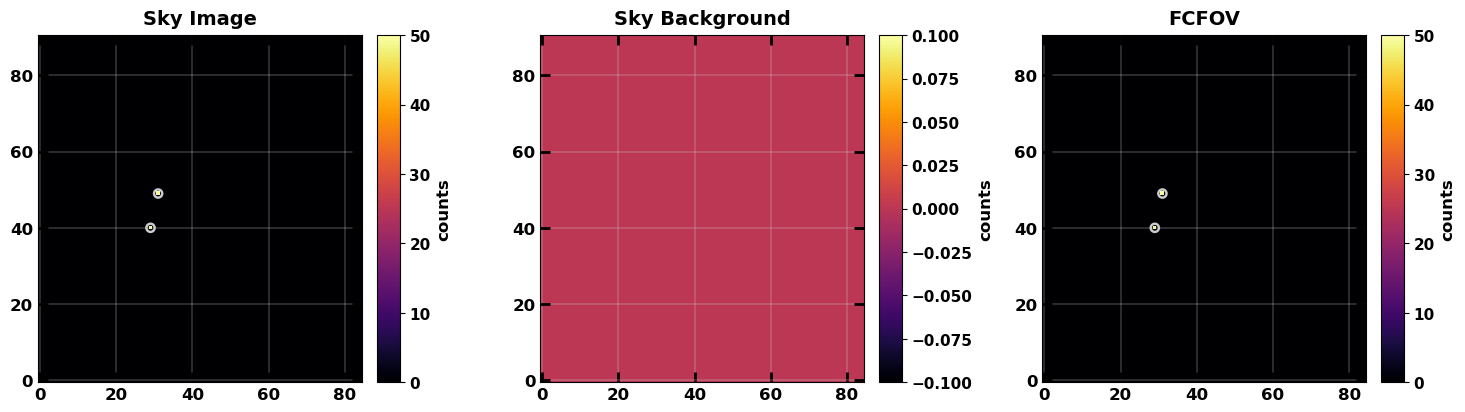

In [45]:
sources_flux = np.array([50]*2)
sources_pos = [(np.random.randint(h, h + n), np.random.randint(v, v + m)),
               (np.random.randint(h, h + n), np.random.randint(v, v + m))]
sky_background_rate = None

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

plot.image_plot([sky_image, sky_background, sky_image*bulk_array],
                ["Sky Image", "Sky Background", "FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[sources_pos, None, sources_pos])

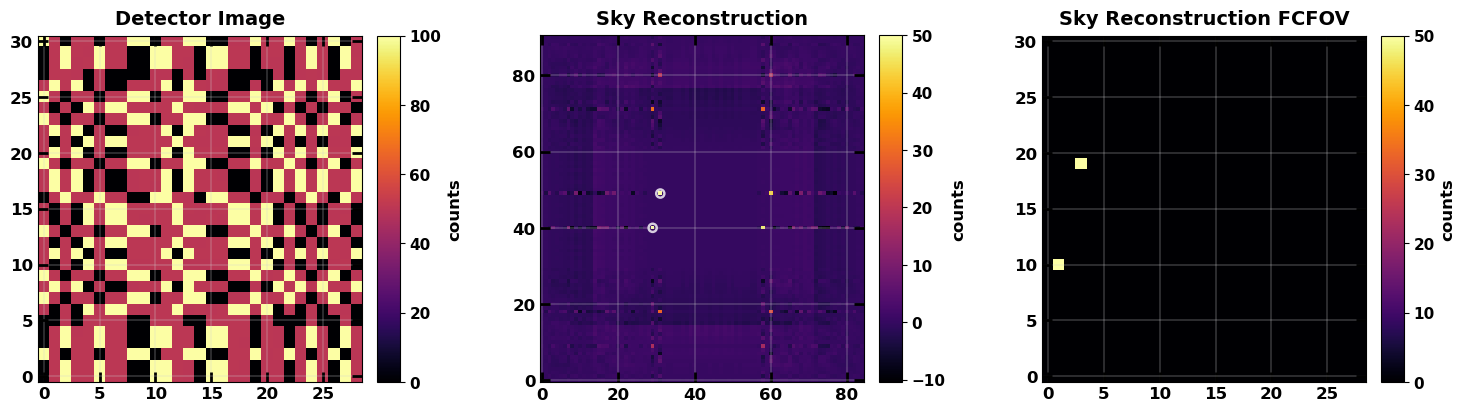

In [50]:
detector_image = correlate(mask, sky_image, mode='valid')
assert detector_image.shape == (n, m)

sky_reconstruction = correlate(pad_decoder, detector_image, mode='valid')
assert sky_reconstruction.shape == sky_shape

plot.image_plot([detector_image, sky_reconstruction, sky_reconstruction[h : -h, v : -v]],
                ["Detector Image", "Sky Reconstruction", "Sky Reconstruction FCFOV"],
                cbarlabel=["counts"]*3, 
                cbarcmap=["inferno"]*3,
                simulated_sources=[None, sources_pos, None])